In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import networkx as nx
import os
import re
from collections import defaultdict
import matplotlib.cm as cm

In [2]:
data_dir = "/Users/asapp/Documents/VAST/sim_results/absfit"  

font = {'family' : 'Helvetica Neue',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

In [10]:
# Collect files grouped by (r1, r2)
def collect_files(folder):
    file_dict = defaultdict(dict)
    pattern = re.compile(r"sim_data_r1_(\d\.\d+)_r2_(\d\.\d+)_trial_(\d+)\.pkl")
    
    for fname in os.listdir(folder):
        match = pattern.match(fname)
        if match:
            r1, r2, trial = float(match.group(1)), float(match.group(2)), int(match.group(3))
            file_dict[(r1, r2)][trial] = os.path.join(folder, fname)
    return file_dict

# Compute mean trajectory and SEM across trials
def compute_average_and_sem(file_dict):
    avg_dict = {}
    sem_dict = {}
    for rpair, trials in file_dict.items():
        trajs = []
        for trial, fpath in sorted(trials.items()):
            with open(fpath, "rb") as fh:
                data = pickle.load(fh)
            freq_timeseries = np.array(data["freq_timeseries"])  # (2,2,timesteps)
            trajs.append(freq_timeseries)
        trajs = np.stack(trajs, axis=0)  # (n_trials,2,2,timesteps)
        avg_dict[rpair] = trajs.mean(axis=0)  # (2,2,timesteps)
        sem_dict[rpair] = trajs.std(axis=0) / np.sqrt(trajs.shape[0])
    return avg_dict, sem_dict

def plot_dgp_selected_nodes(avg_dict, sem_dict):
    plt.figure(figsize=(10, 6))
    
    # Base colors per node
    node_base_cmaps = {
        (0,0): cm.Blues,
        (1,1): cm.Reds
    }
    
    # Normalize shades by number of (r1,r2) pairs
    n_pairs = len(avg_dict)
    shade_vals = np.linspace(0.4, 0.9, n_pairs)  # avoid extremes (too dark/light)
    
    for shade_idx, ((r1, r2), mean_traj) in enumerate(sorted(avg_dict.items())):
        sem_traj = sem_dict[(r1,r2)]
        timesteps = np.arange(mean_traj.shape[2])
        for (g,p), cmap in node_base_cmaps.items():
            color = cmap(shade_vals[shade_idx])  # different shade for each repro prob pair
            label = f'$g={g}, p={p}$ | r1={r1:.2f}, r2={r2:.2f}'
            plt.plot(timesteps, mean_traj[g,p], label=label, color=color)
            plt.fill_between(timesteps,
                             mean_traj[g,p] - sem_traj[g,p],
                             mean_traj[g,p] + sem_traj[g,p],
                             color=color, alpha=0.2)
    
    plt.legend(fontsize=10, loc="upper right", labelspacing=0.3)
    plt.xlabel("Timestep")
    plt.ylabel("Frequency")
    plt.ylim(-0.01, 1.11)
    plt.xlim(-0.1, 500)
    plt.tight_layout()
    plt.show()

def plot_trajectories_grouped(avg_dict, sem_dict, nodes="all", savepath=None):
    """
    Plot trajectories with SEM, grouped legend entries by node.
    
    nodes: "all" or list of (g,p) tuples to plot (e.g. [(0,0),(1,1)] for DGP).
    """
    plt.figure(figsize=(10,6))
    
    # Define node colormaps with safe, non-overlapping ranges
    node_colorranges = {
        (0,0): (cm.Blues,   (0.55, 0.9)),
        (0,1): (cm.Oranges, (0.2, 0.55)),
        (1,0): (cm.Greens,  (0.35, 0.75)),
        (1,1): (cm.Reds,    (0.55, 0.85))
    }
    
    if nodes == "all":
        ordered_nodes = [(0,0),(0,1),(1,0),(1,1)]
        legend_ncol = 2   # split legend into 2 columns for PRGP
    else:
        ordered_nodes = nodes
        legend_ncol = 1   # single column for DGP
    
    n_pairs = len(avg_dict)
    handles_labels = {node: [] for node in ordered_nodes}
    
    for shade_idx, ((r1, r2), mean_traj) in enumerate(sorted(avg_dict.items())):
        sem_traj = sem_dict[(r1,r2)]
        timesteps = np.arange(mean_traj.shape[2])
        for (g,p) in ordered_nodes:
            cmap, (lo,hi) = node_colorranges[(g,p)]
            shade_vals = np.linspace(lo, hi, n_pairs)
            color = cmap(shade_vals[shade_idx])
            label = f'$g$={g}, $p$={p} | $r_1$={r1}, $r_2$={r2}'
            line, = plt.plot(timesteps, mean_traj[g,p], color=color, linewidth=2.5, alpha=0.7)
            plt.fill_between(timesteps,
                             mean_traj[g,p] - sem_traj[g,p],
                             mean_traj[g,p] + sem_traj[g,p],
                             color=color, alpha=0.2)
            handles_labels[(g,p)].append((line, label))
    
    # Build grouped legend
    handles, labels = [], []
    for node in ordered_nodes:
        for h,l in handles_labels[node]:
            handles.append(h)
            labels.append(l)
    
    plt.legend(handles, labels, fontsize=10, loc="upper right", labelspacing=0.3, ncol=legend_ncol)
    plt.xlabel("Timestep")
    plt.ylabel("Frequency")
    plt.ylim(-0.01, 1.01)
    plt.xlim(-1, 500)
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, format="pdf", bbox_inches="tight")

    plt.show()

DGP


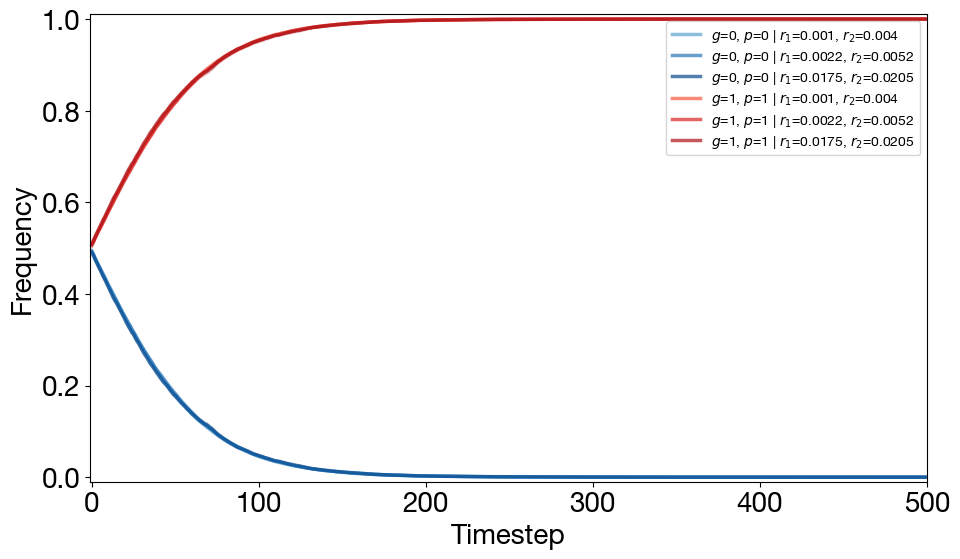

PrGP


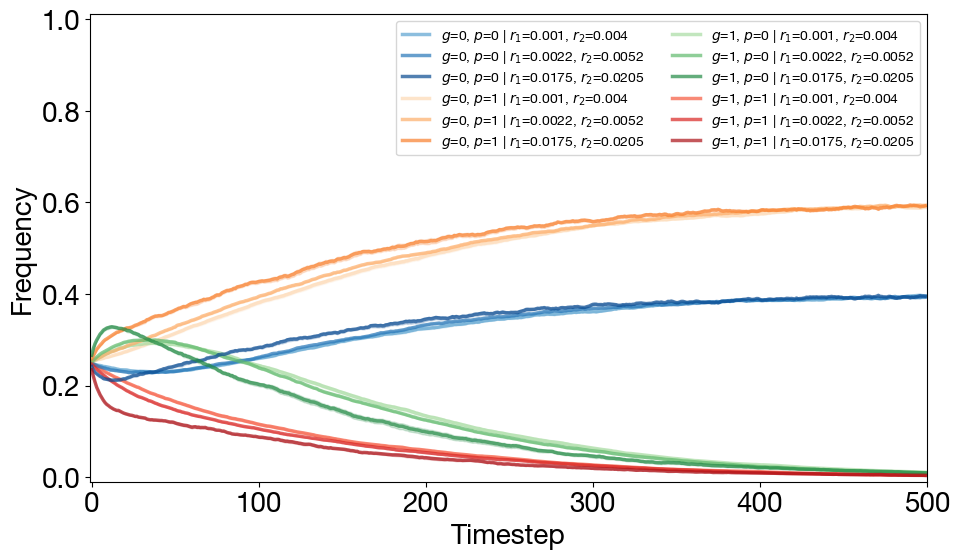

In [11]:
# DGP
print('DGP')
dgp_files = collect_files("/Users/asapp/Documents/VAST/sim_results/absfit/dgp")
dgp_avg, dgp_sem = compute_average_and_sem(dgp_files)
plot_trajectories_grouped(dgp_avg, dgp_sem, nodes=[(0,0),(1,1)], savepath='/Users/asapp/Documents/VAST/r4_figs/dgp_absfit.pdf')

# PRGP
print('PrGP')
prgp_files = collect_files("/Users/asapp/Documents/VAST/sim_results/absfit/prgp")
prgp_avg, prgp_sem = compute_average_and_sem(prgp_files)
plot_trajectories_grouped(prgp_avg, prgp_sem, nodes="all", savepath='/Users/asapp/Documents/VAST/r4_figs/prgp_absfit.pdf')
